In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pwd


/content


In [3]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os 
import time
from torchvision import datasets, models
import torch.nn as nn
import copy

In [4]:
path = Path(".")
data_path = path/ "/content/gdrive/My Drive/Asian_faces/faces_data"
japanese = data_path/"japanese"
korean = data_path/"korean"
chinese = data_path/"chinese"
models_path = data_path/"torch_models"

In [5]:
dataset = torchvision.datasets.ImageFolder(root=data_path, transform=torchvision.transforms.ToTensor())

dataset_len = len(dataset)
val_len = int(0.2*dataset_len)

train_set, val_set = torch.utils.data.random_split(dataset=dataset, lengths=[dataset_len - val_len ,val_len])

image_datasets = {'train': train_set, 'val': val_set}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=0) for x in ['train', 'val']}

dataset_sizes = {'train': dataset_len, 'val': val_len}

classes = dataset.classes
print(classes)

print(dataloaders)

['chinese', 'japanese', 'korean', 'models']
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f80cafa37f0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f80cafa3ac8>}


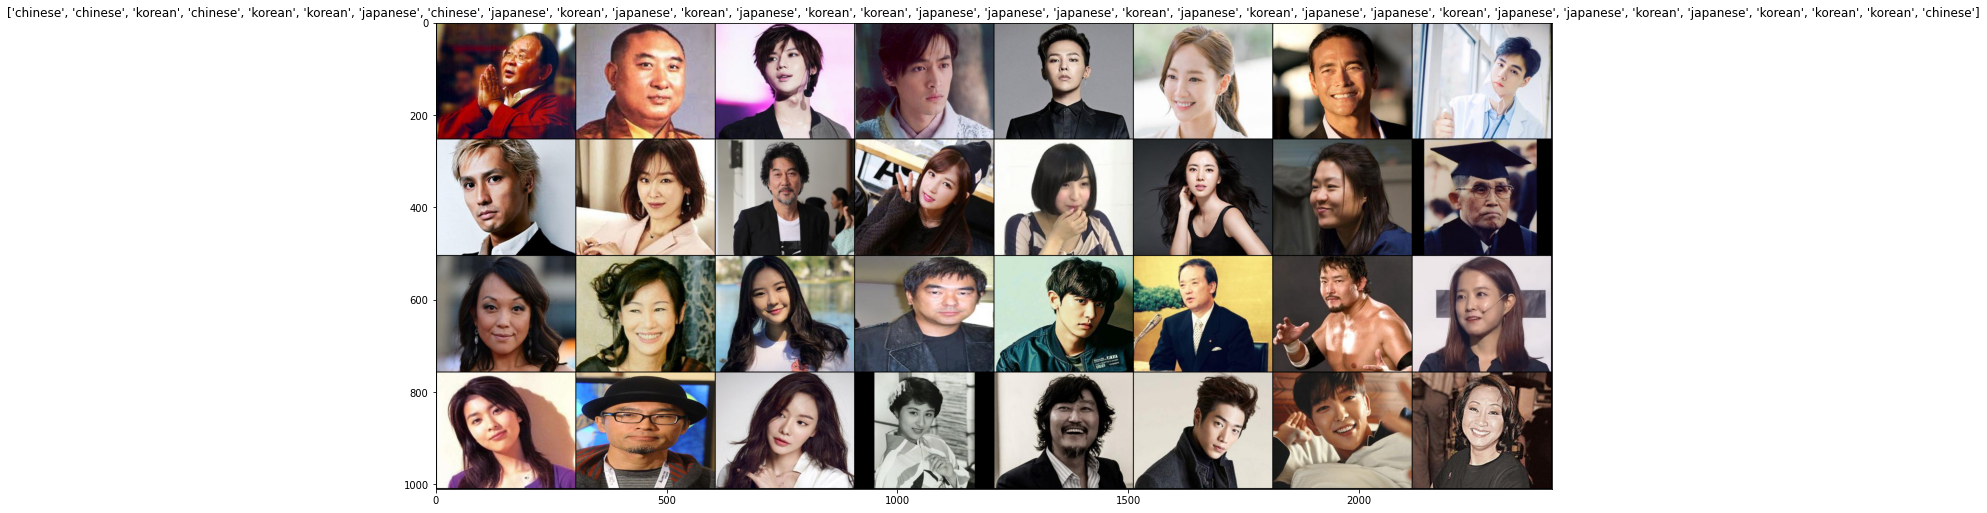

In [6]:
def imshow(out, title=None):
    out = np.transpose(out, (1, 2, 0))
    plt.figure(figsize=[20, 20])
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, class_value = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[classes[x] for x in class_value])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    iteration = 0
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        epoch_loss = 0.0
        epoch_corrects = 0
        loss_train = []
        loss_val = []
        val_points = []

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                iteration += 1

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs,labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                                          
                #if phase == 'train':
                 #   loss_train.append(loss.item())
                #else:
                #    loss_val.append(loss.item())
                #    val_points.append(iteration)

                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
                if phase == 'train':
                    scheduler.step()
                    loss_train.append(loss.item())
                else:
                    loss_val.append(loss.item())
                    val_points.append(iteration)
        
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc:{epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed //60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, loss_train, loss_val, val_points


        

In [9]:
model_ft = models.resnet50(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad == False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_ft.fc.parameters(), lr=1e-3, momentum=0.9)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [10]:
model_ft, loss_train, loss_val, val_points = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 1/5
--------------------
train Loss: 0.9405 Acc:0.3185
val Loss: 1.1339 Acc:0.4111
Epoch 2/5
--------------------
train Loss: 0.8946 Acc:0.3582
val Loss: 1.1301 Acc:0.4216
Epoch 3/5
--------------------
train Loss: 0.8953 Acc:0.3554
val Loss: 1.1288 Acc:0.4251
Epoch 4/5
--------------------
train Loss: 0.8936 Acc:0.3456
val Loss: 1.1307 Acc:0.4181
Epoch 5/5
--------------------
train Loss: 0.8942 Acc:0.3484
val Loss: 1.1304 Acc:0.4251
Training complete in 7m 6s
Best val Acc: 0.425087


In [11]:
print(loss_val, val_points)


[1.1284174919128418, 1.1854076385498047, 1.0998903512954712, 0.9951924085617065, 1.060880184173584, 1.225783348083496, 1.217470645904541, 1.0957633256912231, 1.1656936407089233] [217, 218, 219, 220, 221, 222, 223, 224, 225]


In [12]:
for param in model_ft.parameters():
    param.requires_grad == True

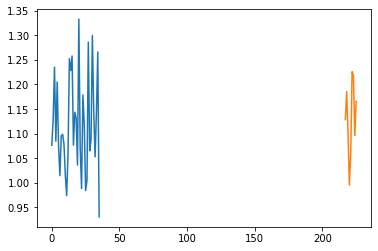

In [13]:
plt.plot(loss_train)
plt.plot(val_points, loss_val)
plt.show()

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
--------------------
train Loss: 0.8955 Acc:0.3436
val Loss: 1.1305 Acc:0.4286
Epoch 2/25
--------------------
train Loss: 0.8949 Acc:0.3422
val Loss: 1.1291 Acc:0.4286
Epoch 3/25
--------------------
train Loss: 0.8941 Acc:0.3547
val Loss: 1.1296 Acc:0.4111
Epoch 4/25
--------------------
train Loss: 0.8939 Acc:0.3484
val Loss: 1.1311 Acc:0.4077
Epoch 5/25
--------------------
train Loss: 0.8930 Acc:0.3561
val Loss: 1.1305 Acc:0.4077
Epoch 6/25
--------------------
train Loss: 0.8943 Acc:0.3477
val Loss: 1.1307 Acc:0.4111
Epoch 7/25
--------------------
train Loss: 0.8939 Acc:0.3449
val Loss: 1.1296 Acc:0.4216
Epoch 8/25
--------------------
train Loss: 0.8937 Acc:0.3547
val Loss: 1.1296 Acc:0.4181
Epoch 9/25
--------------------
train Loss: 0.8942 Acc:0.3443
val Loss: 1.1296 Acc:0.4146
Epoch 10/25
--------------------
train Loss: 0.8960 Acc:0.3547
val Loss: 1.1306 Acc:0.4251
Epoch 11/25
--------------------
train Loss: 0.8936 Acc:0.3519
val Loss: 1.1292 Acc:0.4181
Epoch 12

In [15]:
torch.save(model_ft.state_dict(), models_path)

AttributeError: ignored